## Implementations of Q-iteration and Q-learning

In [241]:
import numpy as np

# This function performs Q_iteration, based on Bellman optimality equation. It's an iterative update of the Q function. The input
# parameters are the discount factor gamma, the number of iterations epochs and the reward matrix R. P corresponds to the 
# probability of having a broken robot, thus staying to the same state with probability P. The function returns the 
# converged Q-function. Convergence is assured by comparison to the previous iteration Q-function.
def Q_iteration(gamma, epochs, R, P=None):
    if P == None:
        P = 0
    Q = np.zeros_like(R)
    Q_next = np.zeros_like(Q)
    
    # iterate for all states and all actions
    for ii in range(epochs):
        for s in range(Q.shape[1]):
            #  if it's a terminal state continue
            if s==0 or s==5:
                    continue
            for a in range(Q.shape[0]):
                # perform the update
                Q_next[a,s] = R[a,s] + gamma * np.amax([(1-P) * Q[:, 2*a - 1 + s] +  P * Q[:,s]])
        
        # compare to the value of the previous iteration and break if converged
        if np.linalg.norm(Q-Q_next) < 1e-8:
            break
            
        #update the value for the next iteration 
        #print(Q)
        Q = np.array(Q_next, copy = True)
        
    Q = np.array(Q_next, copy = True)
    return(Q)           
    

# The implementation of Q_learning algorithm. The input parameters are the discount factor gamma, the learning rate alpha, the 
# parameter epsilon of greedy research, the number of iterations epochs and the reward matrix R. P corresponds to the 
# probability of having a broken robot, thus staying to the same state with probability P.
def Q_learning(gamma, alpha, epsilon, epochs, R, epochs_checkpoints, P = None):
    #if epochs_checkpoints == None:
    #epochs_checkpoints = epochs
    Q_check = np.zeros((len(epochs_checkpoints), R.shape[0], R.shape[1]))
    c = 0
    
    if P == None:
        P = 0
    Q = np.zeros_like(R)
    Q_next = np.zeros_like(Q)
    
    n_states = Q.shape[1] - 1
    end_state = False
    
    # iterate for the set number of epochs
    for ii in range(epochs):
        # set an arbitrary initial state. Continue if the initial state is also a terminal state.
        s = np.rint(n_states * np.random.rand()).astype(int)
        if s==0 or s==5:
                if (ii == epochs_checkpoints).any():
                    #print(ii)
                    Q_check[c,:,:] = np.array(Q_next, copy = True) 
                    c += 1
                continue
        # each episode include a number of steps updating the Q-function until the agent reaches a terminal state, when the
        # running episode ends and we move to the next iteration
        while(not end_state):
            # set current Q function to the value extracted from the previous iteration.
            Q = np.array(Q_next, copy = True)
            

            # Apply ε-greedy research. The second condition applies for the case of multiple occurences of the max value.
            # Withoout this condition the first occurence would always be returned, meaning that always the agent would take
            # the action left
            t = np.random.rand()
            if t<epsilon or (Q[:,s] == np.amax(Q[:, s]) * np.ones_like(Q[:,s])).all:
                a = np.rint(np.random.rand()).astype(int)
            else:
                a = np.argmax([Q[:,s]])
        
            # Determine the next state based on action a. Then update the Q function.
            # If we get a reward for ending up in a terminal state set end_state to true and continue with the next epoch
            s_next = 2*a - 1 + s
            Q_next[a,s] =  Q[a,s] + alpha * (R[a,s] + gamma * np.amax([(1-P)*Q[:,s_next] + P*Q[:, s]]) - Q[a,s])
            #Q_next[a,s] = Q[a,s] + alpha/(ii+1) * (R[a,s] + gamma * max(Q[:,s_next]) - Q[a,s])
            if R[a,s]>0:
                end_state = True   
            s = s_next    
        end_state = False
        if ((ii == epochs_checkpoints).any()):
            #print(ii)
            Q_check[c,:,:] = np.array(Q, copy = True) 
            c += 1
                                       
    Q = np.array(Q_next, copy = True)
    #Q_check[c,:,:] = np.array(Q, copy = True)
    
    return Q_check

In [242]:
QQ = Q_learning(gamma, 1, epsilon, epochs, R, epochs_checkpoints, 0)
#print(epochs, epochs_checkpoints.shape)
#print(QQ)

In [222]:
print(QQ)

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]]]


In [33]:
epochs = 1000
gamma = 0.5

Q = np.zeros((2,6))
R = np.zeros_like(Q)
R[0,1] = 1
R[1,4] = 5

QQ = Q_iteration(gamma, 1000, R, 0)
print(np.round(QQ, 6))

[[0.    1.    0.5   0.625 1.25  0.   ]
 [0.    0.625 1.25  2.5   5.    0.   ]]


In [58]:
QQ = Q_learning(gamma, 0.1,  0, 12000, R, 0)
print(QQ)

[[0.    1.    0.5   0.625 1.25  0.   ]
 [0.    0.625 1.25  2.5   5.    0.   ]]


## Visualizations 

In [209]:
from matplotlib import pyplot as plt

def divQlearn_alpha(Q_star, gamma, alpha, epsilon, epochs, rep, R, epochs_checkpoints, P):
    
    fig = plt.figure(figsize = (10,5))
    aa = np.arange(len(epochs_checkpoints))
    for a in alpha:
        L2diff = np.zeros((rep, len(epochs_checkpoints)))
        for i in range(rep):
            Q_learn = Q_learning(gamma, a, epsilon, epochs, R, epochs_checkpoints, P)
            diff = np.reshape((Q_learn - Q_star), (Q_learn.shape[0], Q_learn.shape[1]*Q_learn.shape[2]))
            L2diff[i,:] = np.linalg.norm(diff, axis = 1)

        mean_L2diff = np.mean(L2diff, axis = 0)
        std_L2diff = np.std(L2diff, axis = 0)

        plt.fill_between(aa, mean_L2diff - std_L2diff,
                             mean_L2diff + std_L2diff, alpha=0.1)
        plt.plot(aa, mean_L2diff, 'o-')
    
    plt.title('L2-norm difference berween Q-learning and groundtruth')
    plt.xlabel("Number of interactions - epochs")
    plt.ylabel("L2-norm difference")
    labels = ['0', '10', '100', '500', '1000', '10000']
    plt.xticks(aa, labels, rotation = 'horizontal')
    plt.grid()
    plt.legend(['a=1', 'a=0.1', 'a=0.01', 'a=0.001'], loc="best")
    
    
def divQlearn_epsilon(Q_star, gamma, alpha, epsilon, epochs, rep, R, P):
    
    fig = plt.figure(figsize = (10,5))
    aa = np.arange(len(epochs_checkpoints))
    
    for e in epsilon:
        diff = np.zeros(rep)
        mean_diff = np.zeros(len(epochs))
        std_diff = np.zeros_like(mean_diff)
        for i in range(len(epochs)):
            for j in range(rep):
                Q = Q_learning(gamma, alpha, e, epochs[i], R, P)
                diff[j] = np.linalg.norm(Q - Q_star)
            mean_diff[i] = np.mean(diff)
            std_diff[i] = np.std(diff)
        
    
        plt.fill_between(aa, mean_diff - std_diff,
                         mean_diff + std_diff, alpha=0.1)
        lines = plt.plot(aa, mean_diff, 'o-')
    
    plt.title('L2-norm difference berween Q-learning and groundtruth')
    plt.xlabel("Number of interactions - epochs")
    plt.ylabel("L2-norm difference")
    labels = ['0', '10', '100', '500', '1000', '10000']
    plt.xticks(aa, labels, rotation = 'horizontal')
    plt.grid()
    plt.legend(['e=0', 'e=0.1', 'e=0.2', 'e=0.3', 'e=0.5', 'e=1' ], loc="best")
        
        
        

### L2 diff vs epochs - fixed epsilon

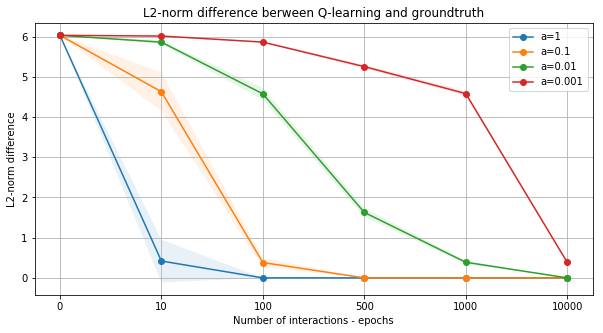

In [243]:
epochs_checkpoints = np.array([0, 10, 100, 500, 1000, 10000])
epochs = 10001
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0
rep = 20

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, epochs_checkpoints, 0)

In [126]:
epochs = np.array([0, 10, 100, 500, 1000, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0.1
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

TypeError: divQlearn_alpha() missing 1 required positional argument: 'P'

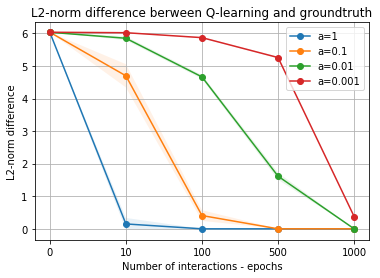

In [84]:
epochs = np.array([0, 10, 100, 500, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0.2
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

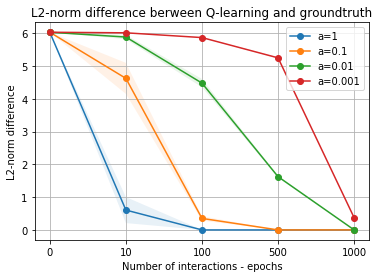

In [87]:
epochs = np.array([0, 10, 100, 500, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0.3
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

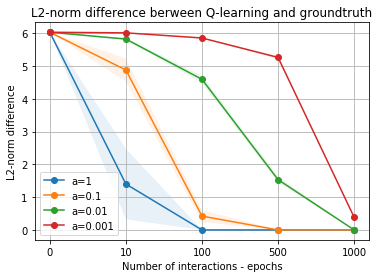

In [85]:
epochs = np.array([0, 10, 100, 500, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 0.5
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

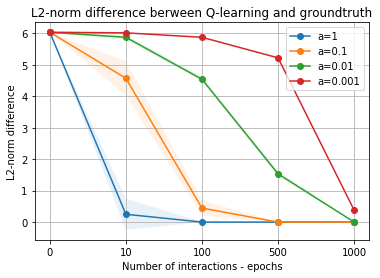

In [86]:
epochs = np.array([0, 10, 100, 500, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1, 0.01, 0.001]
epsilon = 1
rep = 5

divQlearn_alpha(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

### L2 diff vs epochs - fixed alpha

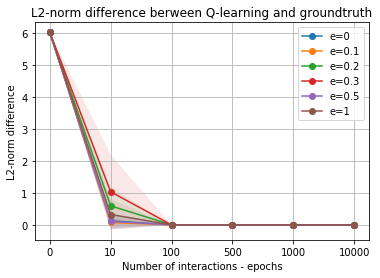

In [90]:
epochs = np.array([0, 10, 100, 500, 1000, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = 1
epsilon = [0,0.1,0.2,0.3,0.5,1]
rep = 5

divQlearn_epsilon(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

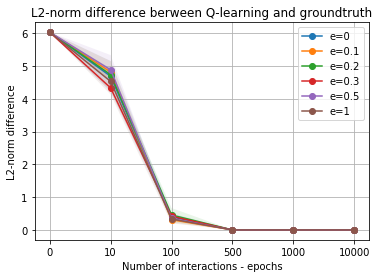

In [91]:
epochs = np.array([0, 10, 100, 500, 1000, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = 0.1
epsilon = [0,0.1,0.2,0.3,0.5,1]
rep = 5

divQlearn_epsilon(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

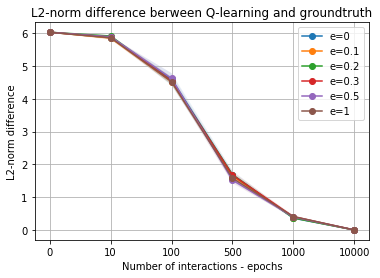

In [92]:
epochs = np.array([0, 10, 100, 500, 1000, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = 0.01
epsilon = [0,0.1,0.2,0.3,0.5,1]
rep = 5

divQlearn_epsilon(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

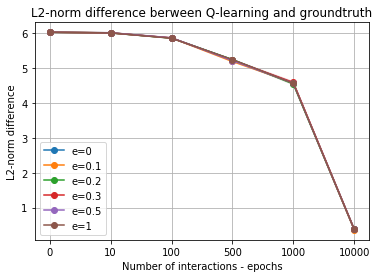

In [93]:
epochs = np.array([0, 10, 100, 500, 1000, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = 0.001
epsilon = [0,0.1,0.2,0.3,0.5,1]
rep = 5

divQlearn_epsilon(Q_star, 0.5, alpha, epsilon, epochs, rep, R, 0)

### Stochastic transitions

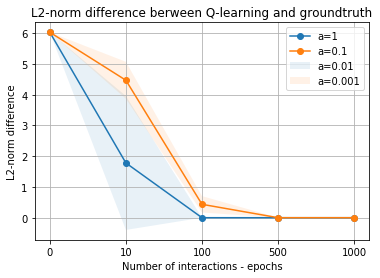

In [99]:
epochs = np.array([0, 10, 100, 500, 1000, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1]
epsilon = 0
rep = 5

divQlearn(Q_star, gamma, alpha, epsilon, epochs, rep, R, 0.3)

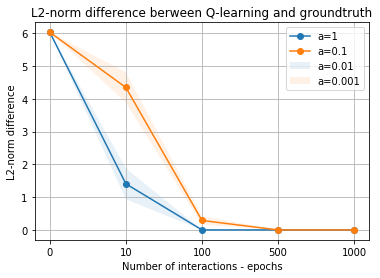

In [108]:
epochs = np.array([0, 10, 100, 500, 10000])
Q_star = np.array([[0.0, 1.0, 0.5, 0.625, 1.25, 0.0], [0.0, 0.625, 1.25, 2.5, 5.0, 0.0]])
#print(Q_star)

gamma = 0.5
alpha = [1, 0.1]
epsilon = 0.8
rep = 5

divQlearn(Q_star, gamma, alpha, epsilon, epochs, rep, R, 0.3)

In [6]:

epochs = 1000
gamma = 0.5

Q = np.zeros((2,6))
Q_next = np.zeros_like(Q)
R = np.zeros_like(Q)
R[0,1] = 1
R[1,4] = 5
c = 0

for ii in range(epochs):
    c+=1
    for s in range(Q.shape[1]):
        if s==0 or s==5:
                continue
        for a in range(Q.shape[0]):
            Q_next[a,s] = R[a,s] + gamma * max(Q[:, 2*a - 1 + s])
    if np.linalg.norm(Q-Q_next) < 1e-16:
        break
    Q = np.array(Q_next, copy = True)
            
Q = Q_next        
#print(Q)
#print(c)

NameError: name 'np' is not defined

In [147]:
QQ = Q_iteration(gamma, epochs, R, 0.3)
print(QQ)

[[0.     1.     0.725  1.1875 2.375  0.    ]
 [0.     0.7375 1.25   2.5    5.     0.    ]]


## Q-learning

In [56]:
# Implementation of Q-learning
import numpy as np

# Initialize the discount factor gamma, the learning rate alpha, the parameter for ε-greedy epsilon and the number of iterations
# for the Q-learning algorithm epochs
gamma = 0.5
alpha = 0.1
epsilon = 0.1
epochs = 10000 
P = 0

Q = np.zeros((2,6))
Q_next = np.zeros_like(Q)
R = np.zeros_like(Q)
R[0,1] = 1
R[1,4] = 5
n_states = Q.shape[1] - 1
end_state = False


for ii in range(epochs):
    # set an arbitrary initial state. Continue if the initial state is also a terminal state.
    s = np.rint(n_states * np.random.rand()).astype(int)
    if s==0 or s==5:
            continue
    while(not end_state):
        # set current Q function to the value extracted from the previous iteration.
        Q = np.array(Q_next, copy = True)

        # Apply ε-greedy research. The second condition applies for the case of multiple occurences of the max value.
        # Withoout this condition the first occurence would always be returned, meaning that always the agent would take
        # the action left
        t = np.random.rand()
        if t<epsilon or (Q[:,s] == np.amax(Q[:, s]) * np.ones_like(Q[:,s])).all:
            a = np.rint(np.random.rand()).astype(int)
        else:
            a = np.argmax([Q[:,s]])
            
            
        
        # Determine the next state based on action a. Then update the Q function.
        # If we get a reward for ending up in a terminal state set end_state to true and continue with the next epoch
        s_next = 2*a - 1 + s
        Q_next[a,s] = Q[a,s] + alpha * (P * gamma * max(Q[:, s]) + (1-P) * (R[a,s] + gamma * max(Q[:,s_next])) - Q[a,s])
        #Q_next[a,s] = Q[a,s] + alpha/(ii+1) * (R[a,s] + gamma * max(Q[:,s_next]) - Q[a,s])
        if R[a,s]>0:
            end_state = True   
        s = s_next    
    end_state = False
                                       

Q = Q_next    
print(np.round(Q,3))                
                                            

[[0.    1.    0.5   0.625 1.25  0.   ]
 [0.    0.625 1.25  2.5   5.    0.   ]]


## Continuous state - non deterministic transitions

In [193]:
epochs = 10000
epsilon = 0.1
gamma = 0.5
alpha = 0.1

Q = np.zeros((2,6))
Q_next = np.zeros_like(Q)
cc = np.zeros_like(Q)
R = np.zeros_like(Q)
R[0,1] = 1
R[1,4] = 5
n_states = Q.shape[1] - 1
end_state = False

sigma = 0.1

# initial weights for the function approximation
w = np.random.rand(13)

# parameters of the Gaussian for the noise corruption of state transition. Mean and std
mean_g = 0
sigma_g = 0.1

Loss = 0

# basis functions in form (action x state x basis functions)
phi_sa = np.zeros((2,6,13))
phi_sa[:,:,12] = 1

phi_s = np.abs(np.arange(6) - np.arange(6)[:,np.newaxis])
phi_sa[0, :, 0:6] = phi_s
phi_sa[1, :, 6:12] = phi_s

for ii in range(epochs):
    # set an arbitrary initial state. Continue if the initial state is also a terminal state.
    s = np.rint(n_states * np.random.rand()).astype(int)
    s_disc = s
    if s==0 or s==5:
            continue
    while(not end_state):
    #for i in range(1):        
        # Apply ε-greedy research to determine the next action
        t = np.random.rand()
        if t<epsilon:
            a = np.rint(np.random.rand()).astype(int)
        else:
            a = np.argmax([Q[:,s_disc]])
            
        # derive next continuous state, incorporating the Gaussian noise
        # extract also a discretised next state. each state corresponds to the interval s+-0.5
        s_next = 2*a - 1 + s + np.random.normal(mean_g, sigma_g)
        s_next_disc = np.rint(s_next).astype(int)
        if s_next_disc<0:
            s_next_disc = 0
        elif s_next_disc>Q.shape[1] - 1:
            s_next_disc = Q.shape[1] - 1
        
        # Incrementing the counter of interactions with the certain (action, state) for a discretized version of the next state
        # Next update the Q_target approximation, by division with the counter of (action, state)
        cc[a, s_disc] += 1
        Q_next[a, s_disc] = (R[a,s_disc] + gamma * max(Q[:, s_next_disc])) / cc[a, s_disc]
        div = Q_next[a, s_disc] - np.multiply(w, phi_sa[a, s_disc, :])
        Loss += 0.5 * div**2
        w += alpha * np.multiply(div , phi_sa[a, s_disc, :])
        
        if s_next<0.5 or s_next>=4.5:
            end_state = True
            
        s = s_next
        s_disc = s_next_disc
        Qtemp = np.array(Q, copy = True)
        Q = np.array(Q_next, copy = True)
    end_state = False
    if ii%100 == 0 :
        print('Loss', np.linalg.norm(Loss))
        #print('Divergence', np.linalg.norm(Q-Qtemp))

Loss 5.578089670481885
Divergence 0.00017088174982911666
Loss 77.20980680252865
Divergence 0.027472527472527486
Loss 79.34752487483807
Divergence 0.0006105006105006083
Loss 79.53295820328552
Divergence 0.00017403411068569324
Loss 79.56690331735255
Divergence 8.779168788299301e-06
Loss 79.60089990869498
Divergence 8.228827227543464e-05
Loss 79.6488154922247
Divergence 3.867394768188471e-06
Loss 79.6594318989987
Divergence 3.132832080200362e-05
Loss 79.66711539232838
Divergence 2.636296530633686e-05
Loss 79.67423915477988
Divergence 2.4683313093016527e-06
Loss 79.68072030805389
Divergence 1.8526752630797574e-05
Loss 79.68519918792036
Divergence 1.953353908661125e-06
Loss 79.68920344527331
Divergence 1.7290269036585645e-06
Loss 79.6939054773825
Divergence 1.5922147069689137e-06
Loss 79.69885992225026
Divergence 1.0366346692098141e-05
Loss 79.704630697613
Divergence 1.2062580668507818e-06
Loss 79.70680307192997
Divergence 7.536817352767761e-06
Loss 79.71265091915642
Divergence 5.7377481862

In [96]:
print(feat)
print(phi)
print('State', s)
print("Action", a)
print('Next state', s_next)
print('Loss', Loss)

[5.61893906 4.61893906 3.61893906 2.61893906 1.61893906 0.61893906]
[9.68921504e-123 5.02357268e-101 2.60457450e-079 1.35039518e-057
 7.00140137e-036 3.63002044e-014]
State 4.435542129782158
Action 1
Next state 5.61893906045828
Loss 128144.53513347667


In [171]:
# basis functions
phi_sa = np.zeros((2,6,13))
phi_sa[:,:,12] = 1

phi_s = np.abs(np.arange(6) - np.arange(6)[:,np.newaxis])
phi_sa[0, :, 0:6] = phi_s
phi_sa[1, :, 6:12] = phi_s

In [54]:
x = np.array([[0,1,2],[3,4,5]])
print(np.argwhere(x))

[[0 1]
 [0 2]
 [1 0]
 [1 1]
 [1 2]]
